_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders` and `pdpbox`.

In [250]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders
    !pip install pdpbox

# Sprint Challenge: Predict Chicago Food Inspections 🍕

In this challenge, you'll use data from the [Chicago Department of Public Health](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html) to build a model to predict whether a food establishment passed inspection or not.

The purpose of this model is to help inspectors use their time more efficiently by identifying establishments that will likely fail inspection. In other words, this model should be able to predict whether an establishment will fail inspection *before* the inspector arrives at the establishment. 

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Identifying data leakage.
- **Task 3:** Writing a wrangle function.
- **Task 4:** Splitting data into a feature matrix and target vector.
- **Task 5:** Splitting data into training and validation sets.
- **Task 6:** Establishing baseline accuracy.
- **Task 7:** Building model with bagging predictor.
- **Task 8:** Building model with boosting predictor.
- **Task 9 (`stretch goal`):** Plotting ROC curves.
- **Task 10:** Generating classification report.
- **Task 11:** Calculating permutation importances.
- **Task 12 (`stretch goal`):** Creating PDP interaction plot.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `pdpbox`
- `sklearn`
- `xgboost`

**A word of warning:** The virtual machine that will check your answers is small. So, where applicable, don't use huge values for `n_estimators` (`>100`) or `n_jobs` (keep at `-1`). 

If you'd like to import all your libraries at the start of your notebook, you can do so in the code block below 👇

In [251]:
# YOUR CODE HERE
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# encoders
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer

#pipeline
from sklearn.pipeline import make_pipeline

# Bagged Model
from sklearn.ensemble import RandomForestClassifier

# Boosted Models
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 

# Permutation Importance
from sklearn.inspection import permutation_importance  

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set as the index.

In [252]:
'''T1. Import data file.'''
url = 'https://drive.google.com/uc?export=download&id=1aUnQ4AJK4UtW8JL9zPyYUMtkjIgQpqKT'
df = pd.read_csv(url, parse_dates=['Inspection Date'], index_col = 'Inspection Date')
# YOUR CODE HERE
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Type,Violations,Latitude,Longitude,Location,Fail,Serious Violations Found
Inspection Date,,,,,,,,,,,,,,,,,
2017-09-15,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1,2.0
2011-10-20,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0,0.0
2016-04-05,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0,0.0
2016-04-29,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0,0.0
2011-01-10,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0,0.0


**Task 1 Test**

In [253]:
'''T1 Test'''
assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 51916

**Task 2:** Given that this model is supposed to generate predictions *before* an inspection is conducted, identify the numerical feature that is an example of **data leakage.** Assign the column name to the variable `'leaky_col'`.

**Remember:** Leakage is when your feature matrix includes columns that will not be available to your model at the time it make predictions.



In [254]:
'''T2. Identify data leakage column.'''

leaky_col = 'Serious Violations Found'



**Task 2 Test**

In [255]:
'''T2 Test'''
# This is a hidden test. 
# You'll see the result when you submit to Canvas.
assert isinstance(leaky_col, str), '`leaky_col` should be type `str`.'

**Task 3:** Add to the `wrangle` function below so that it does the following:

- Removes the "leaky" column.
- Removes high-cardinality categorical columns (more than `500` categories).
- Removes categorical columns that have only one category.
- Removes numerical columns that are unique identifiers for each observation, not features that would affect the target.

In [256]:
'''T3. Write wrangle function.'''
def wrangle(df):
    return df

#Drop Leaky column
df = df.drop(columns= leaky_col, axis=1)


#Remove categorical columns that have one category
df = df.drop(columns='Inspection ID')
df = df.drop(columns='License #')

#Drop columns with one category
min_thresh = 1

drop_cols_one = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() == min_thresh]

df.drop(drop_cols_one, axis=1, inplace=True)


#Drop high-cardinality categorical variables
threshold = 500

high_card_cols = [col for col in df.select_dtypes('object').columns
                  if df[col].nunique() > threshold]

df.drop(high_card_cols, axis=1, inplace=True)

 # Extract components from date_recorded



df = wrangle(df)

**Task 3 Test**

In [257]:
'''T3 Test'''
assert df.select_dtypes('object').nunique().max() < 500, 'Have you dropped the high-cardinality columns?'
assert df.select_dtypes('object').nunique().min() > 1, 'Have you dropped the column with only one category?'

# II. Split Data

**Task 4:** Split the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'Fail'`.

In [258]:
'''T4. Split feature matrix and target vector.'''
target = 'Fail'
# YOUR CODE HERE
X, y = df.drop(columns=target), df[target]

**Task 4 Test**

In [259]:
'''T4 Test'''
assert y.shape == (51916,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 51916, '`X` has the wrong number of rows.'

**Task 5:** Split your dataset into training and validation sets.

- Your training set (`X_train`, `y_train`) should contain inspections conducted before 2017.
- Your validation set (`X_val`, `y_val`) should contain inspections conducted during or after 2017.

In [260]:
df.head()

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,,
2017-09-15,Restaurant,Risk 1 (High),CHICAGO,60657.0,Canvass,41.938007,-87.644755,1
2011-10-20,Grocery Store,Risk 3 (Low),CHICAGO,60636.0,Complaint Re-Inspection,41.772402,-87.683603,0
2016-04-05,Restaurant,Risk 1 (High),CHICAGO,60649.0,Canvass Re-Inspection,41.758779,-87.575054,0
2016-04-29,Restaurant,Risk 2 (Medium),CHICAGO,60632.0,Canvass,41.812181,-87.707125,0
2011-01-10,School,Risk 1 (High),CHICAGO,60629.0,Canvass,NaN,NaN,0


In [261]:
from xgboost.sklearn import train
'''T5. Split dataset into training and validation sets.'''
# YOUR CODE HERE

# Training 
train_mask = X.index.year < 2017
X_train, y_train = X.loc[train_mask], y.loc[train_mask]

# Validation 
validation_mask = X.index.year >= 2017
X_val, y_val = X.loc[validation_mask], y.loc[validation_mask]


**Task 5 Testing**

In [262]:
'''T5 Test'''
assert len(X_train) == len(y_train) == 41827, 'Your training set has the wrong number of observations.'
assert len(X_val) == len(y_val) == 10089, 'Your validation set has the wrong number of observations.'

# III. Establish Baseline

**Task 6:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [263]:
'''T6. Establish baseline accuracy.'''
# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline accuracy:', baseline_acc)

Baseline accuracy: 0.7506634470557295


**Task 6 Testing**

In [264]:
'''T6 Test'''
assert isinstance(baseline_acc, float), '`baseline_acc` should be type float. Have you defined the variable?'
assert 0.0 <= baseline_acc <= 1.0

# IV. Build Model

In this section, you want to answer the question: Which ensemble method performs better with this data — bagging or boosting?

**Task 7:** Build a model that includes a bagging predictor (`RandomForest`). Your predictor should be part of a pipeline named `model_bag` that includes any transformers that you think are necessary.

In [265]:
'''T7. Build model with bagging predictor.'''
# YOUR CODE HERE
model_bag = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42, n_estimators=75))

model_bag.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Facility Type', 'Risk', 'City',
                                      'Inspection Type'],
                                mapping=[{'col': 'Facility Type',
                                          'data_type': dtype('O'),
                                          'mapping': Grocery Store                                        1
Restaurant                                           2
School                                               3
Long Term Care                                       4
Liquor                                               5
                                                  ... 
religious                                          301
COFFEE  SHOP                                       302
MOBILE FROZEN DESSERTS DISPENSER-NON- MOTORIZED    303
(convenience store)                                304
RESTAURANT/BAR/THEATER                             305
Length: 305, dt...
OUT OF BUSINESS           

**Tast 7 Testing**

In [266]:
'''T7 Testing'''
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
assert isinstance(model_bag, Pipeline), '`model_bag` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert isinstance(model_bag[-1], RandomForestClassifier), 'Your predictor should be a `RandomForestClassifier`.'
assert hasattr(model_bag[-1], 'feature_importances_'), 'Have you trained your model?'

**Task 8:** Build a model that includes a boosting predictor (`GradientBoostingClassifier` from `sklearn` or `XGBClassifier` from `xgboost`). Your predictor should be part of a pipeline named `model_boost` that includes any transformers that you think are necessary. 

In [267]:
'''T8. Build model with boosting predictor.'''
# YOUR CODE HERE
model_boost = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(random_state=42, n_estimators=75, n_jobs=-1))

model_boost.fit(X_train, y_train);

**Task 8 Testing**

In [268]:
'''T8 Testing'''
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
assert isinstance(model_boost, Pipeline), '`model_boost` is the wrong data type. Have you assigned your pipeline to the correct variable name?'
assert any([isinstance(model_boost[-1], XGBClassifier),
            isinstance(model_boost[-1], GradientBoostingClassifier)]), 'Your predictor should be `XGBClassifier` or `GradientBoostingClassifier`.'

# V. Check Metrics

Here are the accuracy scores for your two models. Did you beat the baseline? Which of your two models appears to perform better on your validation set?

In [269]:
print('Bagging Model')
print('Training accuracy:', model_bag.score(X_train, y_train))
print('Validation accuracy:', model_bag.score(X_val, y_val))
print()
print('Boosting Model')
print('Training accuracy:', model_boost.score(X_train, y_train))
print('Validation accuracy:', model_boost.score(X_val, y_val))

Bagging Model
Training accuracy: 0.9076672962440528
Validation accuracy: 0.6818316978887897

Boosting Model
Training accuracy: 0.7539627513328712
Validation accuracy: 0.703934978689662


**Task 9 (`stretch_goal`):** Plot the ROC-curve for both of your models (you can plot them one-at-a-time, side-by-side, or in the same plot).

In [270]:
'''T9. Plot ROC-curve.'''
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn import metrics
# YOUR CODE HERE

#log_reg = LogisticRegression()
#log_reg.fit(X_train, y_train)
#y_pred_proba = log_reg.predict_proba(X_val)[::,1]
#fpr, tpr, _ = metrics.roc_curve(y_val, y_pred_proba)

**Task 10:** Choose one of your models based on your validation accuracy score or your ROC curves. Then create a classification report for that model using your validation data. Save the text of the report to the variable name `model_cr`. 

In [271]:
'''T10. Generate classification report for one model.'''
from sklearn.metrics import classification_report
# YOUR CODE HERE
predictions = model_bag.predict(X_val)
model_cr = classification_report(y_val, predictions)
print(model_cr)

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7092
           1       0.44      0.26      0.33      2997

    accuracy                           0.68     10089
   macro avg       0.59      0.56      0.56     10089
weighted avg       0.65      0.68      0.65     10089



**Task 10 Testing**

In [272]:
assert isinstance(model_cr, str), '`model_cr` should be type `str`.'
assert all(term in model_cr for term in ['precision', 'recall', 'f1-score', 'support']), 'Is this a classification report?'

**Task 11:** Using your best model, create a DataFrame `permutation_importances` with the model's permutation importances based on your validation data.

- The index of the DataFrame should be your feature names.
- The first column should be the mean importance.
- The second column should be the importance standard deviation.

In [273]:
df.head()

,Facility Type,Risk,City,Zip,Inspection Type,Latitude,Longitude,Fail
Inspection Date,,,,,,,,
2017-09-15,Restaurant,Risk 1 (High),CHICAGO,60657.0,Canvass,41.938007,-87.644755,1
2011-10-20,Grocery Store,Risk 3 (Low),CHICAGO,60636.0,Complaint Re-Inspection,41.772402,-87.683603,0
2016-04-05,Restaurant,Risk 1 (High),CHICAGO,60649.0,Canvass Re-Inspection,41.758779,-87.575054,0
2016-04-29,Restaurant,Risk 2 (Medium),CHICAGO,60632.0,Canvass,41.812181,-87.707125,0
2011-01-10,School,Risk 1 (High),CHICAGO,60629.0,Canvass,NaN,NaN,0


In [275]:
'''T11. Create DataFrame of permutation importances.'''
# YOUR CODE HERE
column_to_permute = 'Zip'

model_to_permute = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=75,
                  random_state=42,
                  n_jobs=-1,)
)

model_to_permute.fit(X_train, y_train);

perm_imp = permutation_importance(model_to_permute, X_val, y_val, random_state=42, n_jobs=-1)

data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}

permutation_importances = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')
permutation_importances

,imp_mean,imp_std
City,-0.000198,0.000000
Zip,0.000278,0.000340
Risk,0.000575,0.000290
Facility Type,0.000674,0.000644
Longitude,0.000674,0.000813
Latitude,0.001328,0.000856
Inspection Type,0.002022,0.000662


In [276]:
print(type(permutation_importances))
print(permutation_importances.shape)

<class 'pandas.core.frame.DataFrame'>
(7, 2)


**Task 11 Testing**

In [277]:
'''Task 11 Test'''
assert isinstance(permutation_importances, pd.DataFrame), '`permutation_importances` should be type `DataFrame`.'
assert permutation_importances.shape == (7,2)

**Task 12 (`stretch goal`):** Using your best model, create a PDP interaction plot to examine how `'Latitude'` and `'Longitude'` inform predictions. Remember to user your validation data.

**Note:** Because of the way that `pdp_interact` works, it will throw an error if there are `NaN` values in your validation set. To avoid this problem, be sure to set `dataset` to `X_val.dropna()`.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


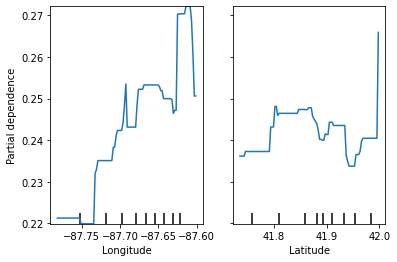

In [278]:
from sklearn.inspection._plot.partial_dependence import plot_partial_dependence
'''T12. Create PDP interaction plot for "Latitude" and "Longitude".'''
features = ['Longitude', 'Latitude']
# YOUR CODE HERE
X_val.dropna()
plot_partial_dependence(model_boost, X_val, features)

What do you think? Is there a relationship between location and failing a food saftey inspection? Answer below.

This task will not be autograded - but it is part of completing the challenge.